In [7]:
import spacy
import pandas as pd
import spacy
from bs4 import BeautifulSoup
import re

In [8]:


df = pd.read_csv('../datasets/preprocessed_nazario_trec07_text.csv')



# define lambda functions for each step
remove_html = lambda body: BeautifulSoup(str(body), 'html.parser').get_text()
remove_punct = lambda body: re.sub(r'[^\w\s]', '', body)
remove_js = lambda body: re.sub(r'<script.*?>.*?</script>', '', body, flags=re.DOTALL)

# apply lambda functions to the 'body' column
df['body'] = df['body'].apply(remove_html)
df['body'] = df['body'].apply(remove_punct)
df['body'] = df['body'].apply(remove_js)

df

,body,label
0,bthis text internal format mail folder notna r...,1
1,nan,1
2,nan,1
3,nan,1
4,nan,1
...,...,...
31724,bthis multipart message mime formatnn_nextpart...,0
31725,bhey allnnim trying create plot semitransparen...,0
31726,bthis multipart message mime formatnn__nextpar...,0
31727,bon sat 21 apr 2007 182418 0700nchromatic wr...,0


In [9]:
import spacy
import pandas as pd
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

# Load the spacy model
nlp = spacy.load("en_core_web_sm")
nlp.max_length=5862775

def preprocess_text(text):
    # Tokenization and lowercasing
    doc = nlp(text.lower()[1:])

    # Removal of punctuation and stopwords, stemming and lemmatization
    tokens = []
    for token in doc:
        if token.text not in STOP_WORDS and token.text not in punctuation:
            tokens.append(token.lemma_)

    return " ".join(tokens)


df['tokens'] = df['body'].apply(preprocess_text)
df

,body,label,tokens
0,bthis text internal format mail folder notna r...,1,text internal format mail folder notna real me...
1,nan,1,
2,nan,1,
3,nan,1,
4,nan,1,
...,...,...,...
31724,bthis multipart message mime formatnn_nextpart...,0,multipart message mime formatnn_nextpart_000_0...
31725,bhey allnnim trying create plot semitransparen...,0,hey allnnim trying create plot semitransparent...
31726,bthis multipart message mime formatnn__nextpar...,0,multipart message mime formatnn__nextpart_001_...
31727,bon sat 21 apr 2007 182418 0700nchromatic wr...,0,sit 21 apr 2007 182418 0700nchromatic wrote...


In [10]:
df.drop(df[df.body == 'nan'].index, inplace=True)

In [11]:
df

,body,label,tokens
0,bthis text internal format mail folder notna r...,1,text internal format mail folder notna real me...
9,bnnnuntitled documentnnnnnn n n n n n nnn n nn...,1,nnnuntitle documentnnnnnn n n n n n nnn n nnn ...
10,bto report spam visit site atnhttpsweepsreward...,1,report spam visit site atnhttpsweepsrewardscom...
12,bnnnpaypalnnnnntnttnttntnnnntntnntpaypal commi...,1,nnnpaypalnnnnntnttnttntnnnntntnntpaypal commit...
13,bnnnnnnnnew page 1nnnnnnnnnnnn nnnnnnnnnnnnnnn...,1,nnnnnnnnew page 1nnnnnnnnnnnn nnnnnnnnnnnnnnnn...
...,...,...,...
31724,bthis multipart message mime formatnn_nextpart...,0,multipart message mime formatnn_nextpart_000_0...
31725,bhey allnnim trying create plot semitransparen...,0,hey allnnim trying create plot semitransparent...
31726,bthis multipart message mime formatnn__nextpar...,0,multipart message mime formatnn__nextpart_001_...
31727,bon sat 21 apr 2007 182418 0700nchromatic wr...,0,sit 21 apr 2007 182418 0700nchromatic wrote...


In [12]:
from sklearn.model_selection import train_test_split

X = df['tokens'].values
y = df['label'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


## CNN 

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D

MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 1000

#Vectorize these text samples into a 2D integer tensor using Keras Tokenizer.
#Tokenizer is fit on training data only, and that is used to tokenize both train
#and test data.
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)



train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


#Converting this to sequences to be fed into neural network. Max seq. len is
#1000 as set earlier. Initial padding of 0s, until vector is of
#size MAX_SEQUENCE_LENGTH
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
val_data = pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)




Found 476153 unique tokens.


In [14]:
import pickle

# We need to save the tokenizer to a file (we'll be using it to tokenize email in production)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [15]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from kerastuner import HyperParameters

# Define the model architecture
def build_model(hp):
    model = keras.Sequential([
        layers.Embedding(MAX_NUM_WORDS, 128, input_length=MAX_SEQUENCE_LENGTH),
        layers.Conv1D(hp.Int('filters', min_value=32, max_value=256, step=32),
                      hp.Int('kernel_size', min_value=3, max_value=7, step=2),
                      activation='relu'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(hp.Int('dense_units', min_value=32, max_value=256, step=32), 
                     activation='relu',
                     kernel_regularizer=regularizers.l2(hp.Choice('l2_regularization', values=[0.001, 0.01, 0.1]))),
        layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)),
        layers.Dense(1, activation='sigmoid')  # Change the number of units and activation function
    ])

    # Compile the model with the chosen hyperparameters
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.001, 0.0001])),
                  loss='binary_crossentropy',  # Use binary_crossentropy for binary classification
                  metrics=['accuracy'])
    return model


/tmp/ipykernel_11853/146814417.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperParameters


In [16]:
#importing random search
from kerastuner import RandomSearch
#creating randomsearch object
tuner = RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 5)
# search best parameter
tuner.search(train_data, y_train, epochs=10, validation_data=(val_data, y_val))


Trial 5 Complete [00h 05m 42s]
val_accuracy: 0.9968307614326477

Best val_accuracy So Far: 0.9974645972251892
Total elapsed time: 00h 43m 10s
INFO:tensorflow:Oracle triggered exit


In [19]:
model=tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters:")
print(best_hyperparameters.values)
#summary of best model
model.summary()

Best hyperparameters:
{'filters': 32, 'kernel_size': 7, 'dense_units': 128, 'l2_regularization': 0.001, 'dropout_rate': 0.2, 'learning_rate': 0.0001}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 128)         1280000   
                                                                 
 conv1d (Conv1D)             (None, 994, 32)           28704     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                      

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
# Defining early stopping to prevent overfitting

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',    
    min_delta = 0,
    patience = 5,
    verbose = 0,
    restore_best_weights = True
)


# Train the best model on the full training data
# model.fit(train_data, y_train)


model.fit(
    train_data, 
    y_train,
    epochs = 30, 
    validation_data = (val_data, y_val),
    verbose = 2,
    callbacks=[early_stopping]
)

Epoch 1/30
592/592 - 40s - loss: 0.0074 - accuracy: 0.9996 - val_loss: 0.0161 - val_accuracy: 0.9970 - 40s/epoch - 68ms/step
Epoch 2/30
592/592 - 39s - loss: 0.0061 - accuracy: 0.9996 - val_loss: 0.0151 - val_accuracy: 0.9975 - 39s/epoch - 66ms/step
Epoch 3/30
592/592 - 39s - loss: 0.0052 - accuracy: 0.9997 - val_loss: 0.0145 - val_accuracy: 0.9975 - 39s/epoch - 66ms/step
Epoch 4/30
592/592 - 35s - loss: 0.0045 - accuracy: 0.9996 - val_loss: 0.0140 - val_accuracy: 0.9975 - 35s/epoch - 59ms/step
Epoch 5/30
592/592 - 35s - loss: 0.0039 - accuracy: 0.9996 - val_loss: 0.0138 - val_accuracy: 0.9970 - 35s/epoch - 59ms/step
Epoch 6/30
592/592 - 35s - loss: 0.0035 - accuracy: 0.9998 - val_loss: 0.0137 - val_accuracy: 0.9975 - 35s/epoch - 59ms/step
Epoch 7/30
592/592 - 35s - loss: 0.0031 - accuracy: 0.9998 - val_loss: 0.0134 - val_accuracy: 0.9975 - 35s/epoch - 59ms/step
Epoch 8/30
592/592 - 35s - loss: 0.0028 - accuracy: 0.9998 - val_loss: 0.0134 - val_accuracy: 0.9968 - 35s/epoch - 59ms/step


185/185 [==============================] - 1s 6ms/step
Accuracy: 99.89858012170384
F1 Score: 99.64114832535886
Recall: 99.64114832535886
Precision: 99.64114832535886
ROC AUC: 99.7910466036243
Confusion Matrix:


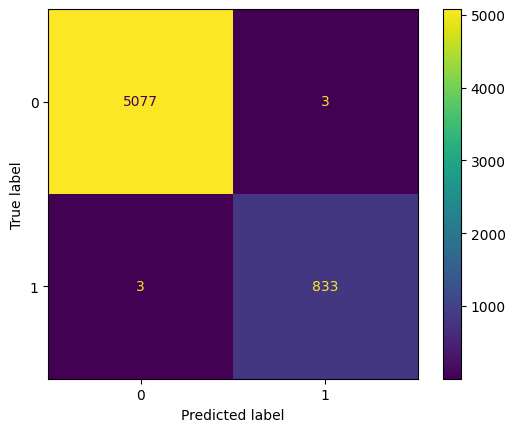

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt
predictions = model.predict(test_data)
predictions = (predictions >= 0.5).astype(int)


# Get the evaluation metrics
print('Accuracy:', accuracy_score(y_test, predictions)*100)
print('F1 Score:', f1_score(y_test, predictions)*100)
print('Recall:', recall_score(y_test, predictions)*100)
print('Precision:', precision_score(y_test, predictions)*100)
print('ROC AUC:', roc_auc_score(y_test, predictions)*100)
print('Confusion Matrix:')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, predictions), display_labels = [0, 1])
cm_display.plot()
plt.show()

In [24]:
## save model
import pickle
filename = '../models/finalized_model_emails_body_classification.sav'
pickle.dump(model, open(filename, 'wb'))


In [28]:

import re
from bs4 import BeautifulSoup
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
import spacy
import pickle 

# define the lambda functions
remove_html = lambda body: BeautifulSoup(str(body), 'html.parser').get_text()
remove_js = lambda body: re.sub(r'<script.*?>.*?</script>', '', body, flags=re.DOTALL)
clean_email = lambda s: remove_js(remove_html(s))

def preprocess_email(body):
    nlp = spacy.load("en_core_web_sm")
    nlp.max_length=5862775

    text = clean_email(body)
    # Tokenization and lowercasing
    doc = nlp(text.lower())

    # Removal of punctuation and stopwords, stemming and lemmatization
    tokens = []
    for token in doc:
        if token.text not in STOP_WORDS and token.text not in punctuation:
            tokens.append(token.lemma_)

    return " ".join(tokens)





loaded_model = pickle.load(open(filename, 'rb'))
tokenizer = pickle.load(open('tokenizer.pickle', 'rb'))

phishing_example = "click the link bellow and fill in your bank account details to win the prise "
legitimate_example = "Hi! how are u? fine u hope. "

phishing_example = preprocess_email(phishing_example)
phishing_example = tokenizer.texts_to_sequences([phishing_example])
phishing_example = pad_sequences(phishing_example, maxlen=MAX_SEQUENCE_LENGTH)

legitimate_example = preprocess_email(legitimate_example)
legitimate_example = tokenizer.texts_to_sequences([legitimate_example])
legitimate_example = pad_sequences(legitimate_example, maxlen=MAX_SEQUENCE_LENGTH)



loaded_model.predict([phishing_example])
loaded_model.predict([legitimate_example])

1/1 [==============================] - 0s 20ms/step


array([[0.00382375]], dtype=float32)